In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
!export TRAIN_PATH='./solar/TRAIN'
TRAIN_PATH='./solar/TRAIN'
#!export TRAIN_PATH='/scratch/spin4d/TRAIN'
#TRAIN_PATH='/scratch/spin4d/TRAIN'

---
# SPIN-4D data set

This data set is taken from the output of a magnetohydrodynamic simulation (**MURaM**) of the Sun's atmosphere. 
5 simulations were run with differing initial conditions then run through time.

In [3]:
!ls $TRAIN_PATH|grep SPIN4D_SSD

SPIN4D_SSD
SPIN4D_SSD_100G
SPIN4D_SSD_200G
SPIN4D_SSD_50G
SPIN4D_SSD_50G_V


---
# SPIN-4D MURaM cube snapshots

Each of these 5 runs outputs a series of snapshots in time of the state of the physical parameters of the solar atmosphere (12 of them).
This training set selects snapshots 12 minutes apart so that convective cells in the solar atmosphere are uncorrelated in successive snapshots.


In [4]:
!ls $TRAIN_PATH/SIR/SPIN4D_SSD_200G/*-15648.h5

./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-032194-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-035416-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-038638-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-041860-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-045082-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-048303-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-051525-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-054747-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-057969-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-061191-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-064413-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-067635-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-070857-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-074079-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-077301-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-080521-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-083740-15648.h5
./solar/TRAIN/SIR/SPIN4D_SSD_20

---
# synthetic Stokes profiles
For each snapshot the **SIR** program is used to synthesize line of sight **Stokes** profiles of absorption lines.
These absorption lines are specific to one elemental electron's energy state which determines the wavelength band.
The data set includes synthetic Stokes profiles for two lines, FeI 6302 and 15648 (units are Angstroms).
Each (Y,X) pixel of the MURaM cube represents a line of sight and a Stokes vector is synthesized and saved in HDF5 format. 

In [5]:
stokesPath = os.path.join(TRAIN_PATH,'SIR/SPIN4D_SSD_200G','stokes-045082-6302.h5')
stokes = h5py.File(stokesPath,'r')

In [6]:
print(stokesPath)
print(stokes.keys())

./solar/TRAIN/SIR/SPIN4D_SSD_200G/stokes-045082-6302.h5
<KeysViewHDF5 ['I', 'Q', 'U', 'V', 'lambda']>


---
# The stokes profile HDF5 file
Each Stokes parameter is stored as a spatial matrix with the number of wavelengths sampled as "channels" or a 3rd dimension.
The wavelengths are stored in the HDF5 file in the "lambda" object.

In [7]:
si = np.array(stokes['I'])
sq = np.array(stokes['Q'])
su = np.array(stokes['U'])
sv = np.array(stokes['V'])
wl = np.array(stokes['lambda'])
stokes.close()

In [8]:
print(si.shape)
print(wl.shape)


(1536, 1536, 276)
(276,)


---
# Channels / the wavelength dimension
The wavelength dimension varies with the species:
-  6302A line: 276 
- 15648A line: 256

(Maybe it is reasonable to trim the 6302 WL dimension to the same as the 15648 data?)

In [9]:
si = si[:,:,10:266]
sq = sq[:,:,10:266]
su = su[:,:,10:266]
sv = sv[:,:,10:266]

---
# Dimensionality of the data
One can treat the Stokes profiles as a 3D volume with 2 spatial dimensions, wavelength in the z dimension and 4 channels:
- 6302:  shape (1536, 1536, 276, 4)
- 15648: shape (1536, 1536, 256, 4)

In [10]:
X = np.empty((1536, 1536, 256, 4))
X[:,:,:,0] = si
X[:,:,:,1] = sq
X[:,:,:,2] = su
X[:,:,:,3] = sv
X.shape

(1536, 1536, 256, 4)

or as a 2D spatial image with concatenated wavelengths as channels:
- 6302:  shape (1536, 1536, 276*4)
- 15648: shape (1536, 1536, 256*4)

In [11]:
X = np.reshape(X, (1536, 1536, 256*4))
X.shape
X = []

In [12]:
colormap="gray"
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

---
# Visualizing Stokes data

Here we display I, Q, U, and V as images as if we were looking from Earth toward the center of the simulation cube.
We observe the polarized light as it leaves the surface of last scattering. 
We choose a wavelength index of 100 (in the range 0 to 275) to avoid polarized wavelength bands with absorption.
This makes the (Q, U, V) plots featureless (low polarization signal)
The X axis is east/west on the surface of the Sun.
The Y axis is north/south on the surface of the Sun.

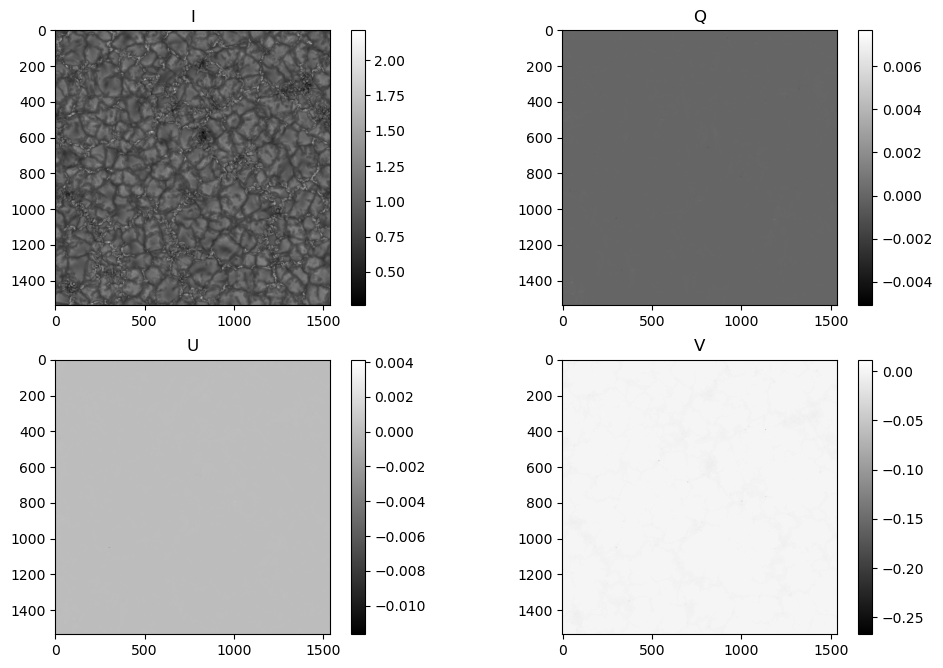

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
plt.subplot(2, 2, 1)
plt.imshow(si[:,:,100],cmap=colormap)
plt.title('I')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(sq[:,:,100],cmap=colormap)
plt.title('Q')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(su[:,:,100],cmap=colormap)
plt.title('U')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(sv[:,:,100],cmap=colormap)
plt.title('V')
plt.colorbar()

---
# Quiet Sun and Granules

The Intensity map shows what one might see through a telescope. 
There are visible granules, convective cells in the Sun's atmosphere.
Other features may be observed. The Q, U and V plots above showed effectively no polarized light.
What could we do to plot Q, U and V images that show signal?
hint: we used "channel" 100 above but there are many other wavelength samples in the data.

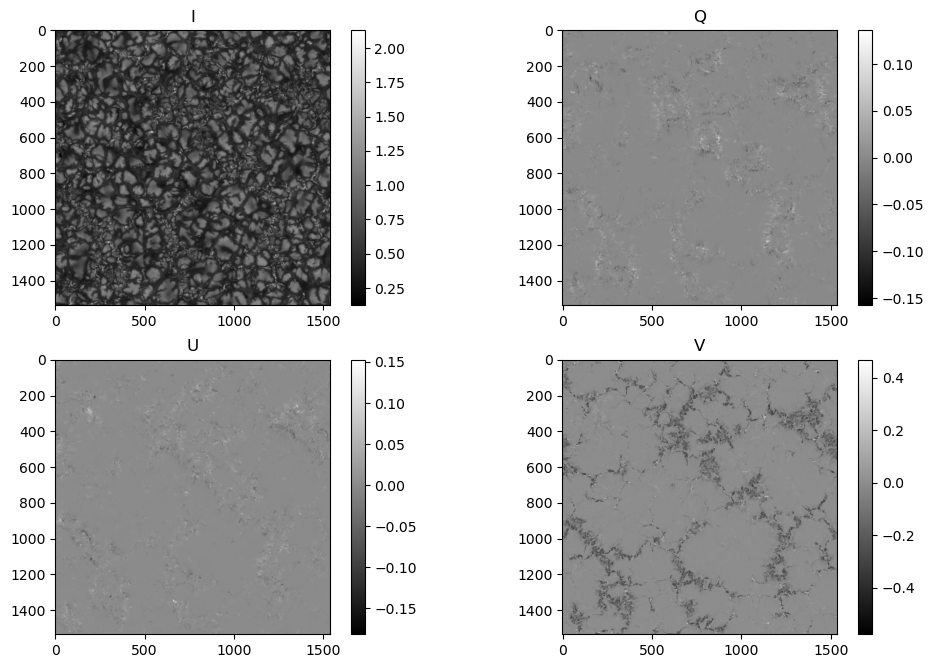

In [14]:
plt.subplot(2, 2, 1)
plt.imshow(si[:,:,180],cmap=colormap)
plt.title('I')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(sq[:,:,180],cmap=colormap)
plt.title('Q')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(su[:,:,180],cmap=colormap)
plt.title('U')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(sv[:,:,180],cmap=colormap)
plt.title('V')
plt.colorbar()

---
# Butterfly plots
Channel 180 is in the wavelength band where polarization signal is present.

Let's shift our view and look at the wavelength dimension for a vertical cross-section of the maps above.

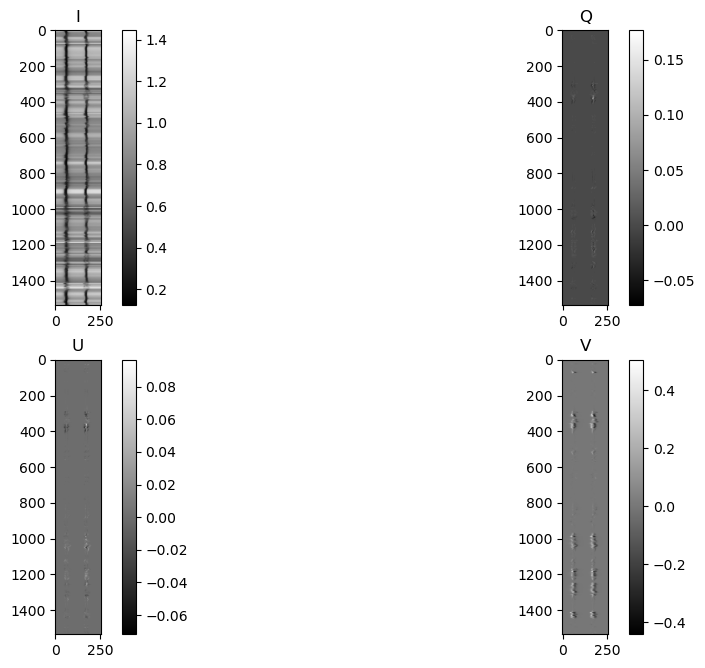

In [15]:
plt.subplot(2, 2, 1)
plt.imshow(si[:,1250,:],cmap=colormap)
plt.title('I')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(sq[:,1250,:],cmap=colormap)
plt.title('Q')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(su[:,1250,:],cmap=colormap)
plt.title('U')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(sv[:,1250,:],cmap=colormap)
plt.title('V')
plt.colorbar()

---
# Spatial interpretation

Since this is a vertical slice (x=1250) through the spatial map you can see that only certain regions of y have signal present in the Q, U and V plots.

Also, note that the I plot shows typical absorption lines but polarization signals are present only in specific spatial regions.

In [21]:
si = []
sq = []
su = []
sv = []

---
# SPIN-4D MURam Cube data

Under the TRAIN directory are subdirectories for each initial configuration of the MURaM simulation.

In [22]:
!ls $TRAIN_PATH|grep SPIN4D_SSD

SPIN4D_SSD
SPIN4D_SSD_100G
SPIN4D_SSD_200G
SPIN4D_SSD_50G
SPIN4D_SSD_50G_V


---
# Simulation MURaM cube snapshots

For a given simulation run there are ~20 snapshots of the MURaM cube parameter values.
The MURaM simulation grid is 1536 x 1536 x 128 or 1536 "pixels" square sampled at 128 levels in the (simulated) solar atmosphere.

---
#  MURaM cube dimensionality
The MURaM cube axes correspond to solar (X, Y, Z) where:
- Solar Y = North to South
- Solar X = East to West
- Solar Z = Center to Surface


Each snapshot consists of 12 files each storing 1 of the 12 parameters. Each file contains a 3D numpy array with shape: (1536, 1536, 128).
The data is stored in the file in (X, Y, Z) order so we need to swap axes after reading in the data.
Each snapshot is uniquely identified by a sequence number suffix, e.g. **006422**.


In [26]:
!ls $TRAIN_PATH/SPIN4D_SSD_200G/3D | grep 006422

subdomain_0.006422
subdomain_1.006422
subdomain_10.006422
subdomain_11.006422
subdomain_2.006422
subdomain_3.006422
subdomain_4.006422
subdomain_5.006422
subdomain_6.006422
subdomain_7.006422
subdomain_8.006422
subdomain_9.006422


---
# MURaM cube parameters

The following table is a key to mapping the numeric "subdomain_<n>" file names to recognizable parameters of physics equations.

Abbrev|File Name|Parameter
---|---|---
rho|subdomain_0|density
vx|subdomain_1|velocity_x
vy|subdomain_2|velocity_y
vz|subdomain_3|velocity_z
eint|subdomain_4|internal electron pressure
Bx|subdomain_5|magnetic field_x
By|subdomain_6|magnetic field_y
Bz|subdomain_7|magnetic field_z
T|subdomain_8|temperature
P|subdomain_9|pressure
ne|subdomain_10|number of electrons
tau500|subdomain_11|opacity at 500nm

In [27]:
cubeParam = {
  'rho': 'subdomain_0',
  'vx': 'subdomain_1',
  'vy': 'subdomain_2',
  'vz': 'subdomain_3',
  'eint': 'subdomain_4',
  'Bx': 'subdomain_5',
  'By': 'subdomain_6',
  'Bz': 'subdomain_7',
  'T': 'subdomain_8',
  'P': 'subdomain_9',
  'ne': 'subdomain_10',
  'tau': 'subdomain_11',
}

In [28]:
cube = {}

In [29]:
def read_cube(param_key, model, sequence):
  paramPath = os.path.join(TRAIN_PATH,'SPIN4D_SSD_{0}/3D'.format(model),cubeParam[param_key]+'.'+sequence)
  print('get {0} from {1}'.format(param_key, paramPath))
  tmp = np.fromfile(paramPath, dtype = np.float32)
  tmpa = tmp.reshape((1536,1536,128))
  return tmpa.transpose(1, 0, 2)

---
# Visualize slices of the Sun's atmosphere

We can visualize a cross sectional slice at half the depth of the cube grid (z = 64)
and plot a single line of sight looking straight up the cube (the surface of the Sun is at the right)

---
# Magnetic field strength

The magnetic field is described by 3 parameters: (Bx, By, Bz).

get Bz from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_7.006422


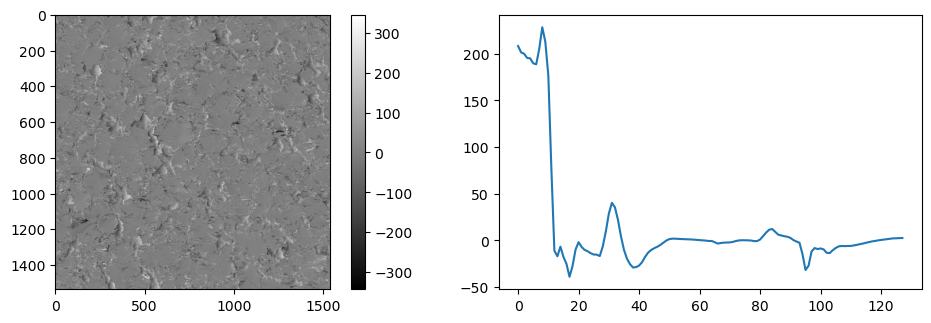

In [31]:
cube['Bz'] = read_cube('Bz', '200G', '006422')
cube['Bz'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['Bz'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['Bz'][750,750,:])
cube['Bz'] = []

get Bx from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_5.006422


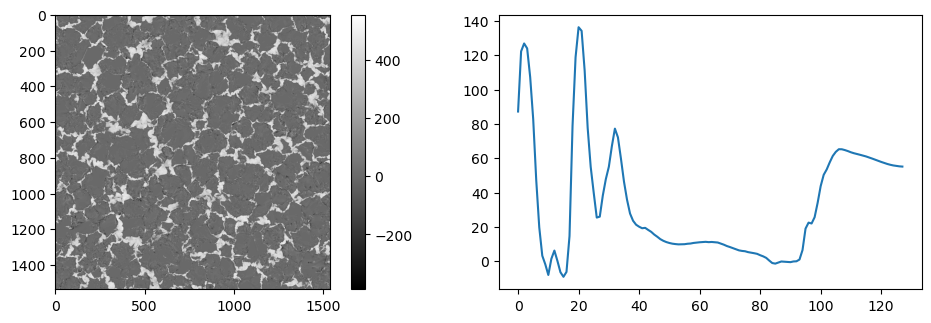

In [32]:
cube['Bx'] = read_cube('Bx', '200G', '006422')
cube['Bx'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['Bx'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['Bx'][750,750,:])
cube['Bx'] = []

get By from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_6.006422


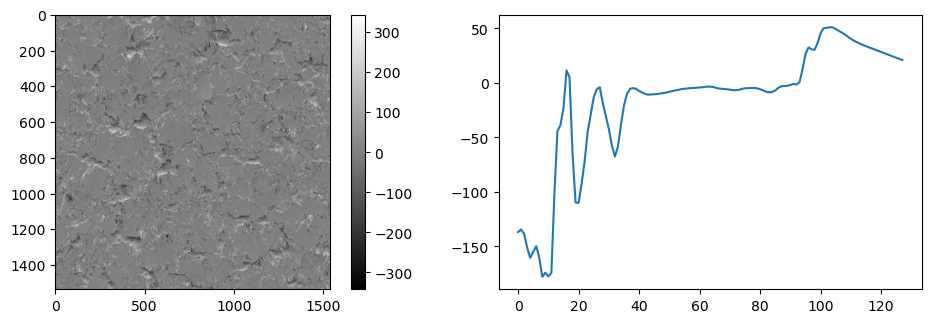

In [33]:
cube['By'] = read_cube('By', '200G', '006422')
cube['By'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['By'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['By'][750,750,:])
cube['By'] = []

---
# Temperature, Pressure and Density

get T from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_8.006422


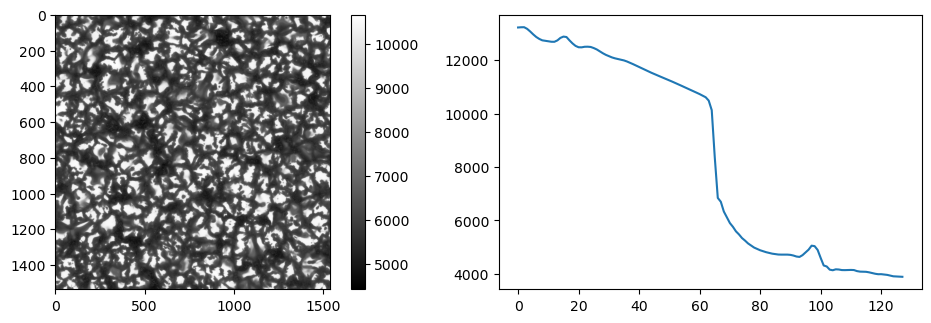

In [34]:
cube['T'] = read_cube('T', '200G', '006422')
cube['T'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['T'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['T'][750,750,:])
cube['T'] = []

get P from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_9.006422


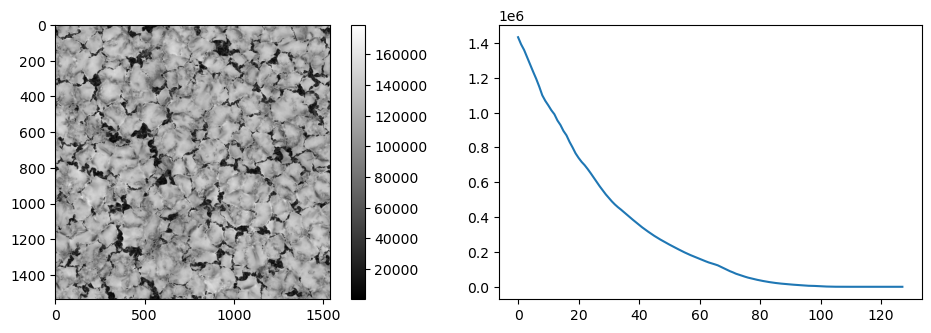

In [35]:
cube['P'] = read_cube('P', '200G', '006422')
cube['P'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['P'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['P'][750,750,:])
cube['P'] = []

get rho from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_0.006422


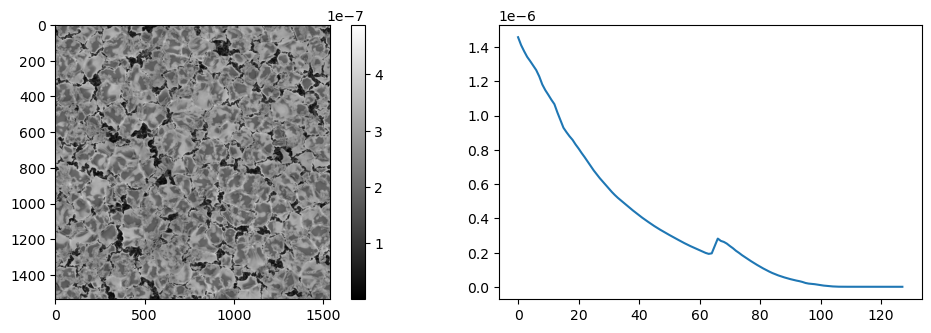

In [36]:
cube['rho'] = read_cube('rho', '200G', '006422')
cube['rho'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['rho'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['rho'][750,750,:])
cube['rho'] = []

---
# Number of electrons, internal electron pressure

get ne from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_10.006422


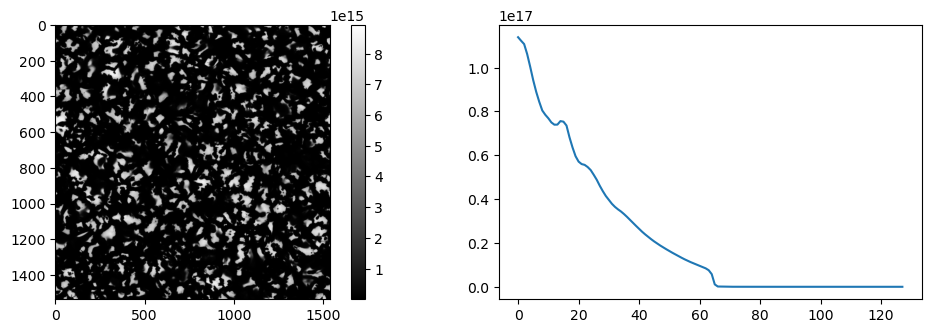

In [37]:
cube['ne'] = read_cube('ne', '200G', '006422')
cube['ne'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['ne'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['ne'][750,750,:])
cube['ne'] = []

get eint from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_4.006422


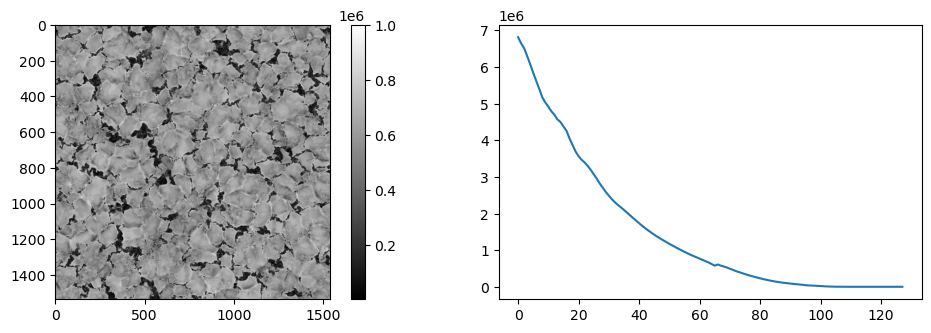

In [38]:
cube['eint'] = read_cube('eint', '200G', '006422')
cube['eint'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['eint'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['eint'][750,750,:])
cube['eint'] = []

---
# Opacity

By convention opacity (tau) is integrated at 500nm

get tau from ./solar/TRAIN/SPIN4D_SSD_200G/3D/subdomain_11.006422


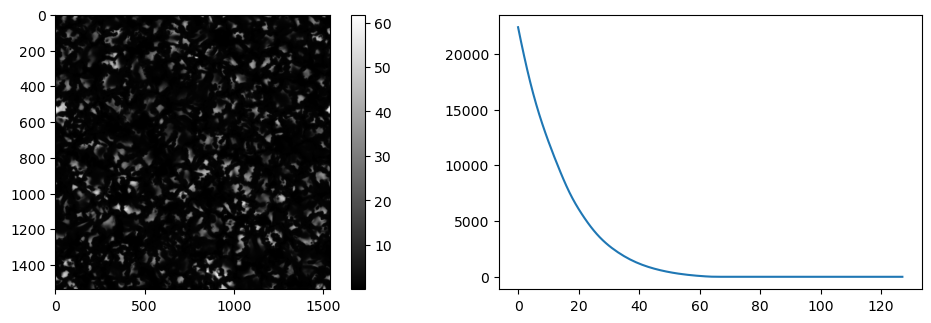

In [39]:
cube['tau'] = read_cube('tau', '200G', '006422')
cube['tau'].shape
plt.subplot(2, 2, 1)
plt.imshow(cube['tau'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(2, 2, 2)
plt.plot(cube['tau'][750,750,:])
cube['tau'] = []